<a href="https://colab.research.google.com/github/Aphilak660510747/229352-stat/blob/main/Lab02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

# For Fashion-MNIST
from tensorflow.keras.datasets import fashion_mnist

# For 20 Newsgroups
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## Part 1: Marketing Campaign Dataset - Manual Data Preprocessing & Logistic Regression

### Load the Marketing Campaign Dataset ([Data Information](https://archive.ics.uci.edu/dataset/222/bank+marketing))

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be (`'yes'`) or not (`'no'`) subscribed.

In [2]:
# URL for the raw Bank Marketing dataset CSV
bank_url = 'https://raw.githubusercontent.com/donlap/ds352-labs/main/bank.csv'

# Load the dataset
# - sep=';' is crucial as it's semicolon-separated
# - na_values=['unknown'] converts 'unknown' strings to NaN
df = pd.read_csv(bank_url, sep=';', na_values=['unknown'])
df = df.drop(["emp.var.rate", "cons.price.idx", "cons.conf.idx",	"euribor3m", "nr.employed"], axis=1)
print("Shape of the dataset:", df.shape)
df.head()

Shape of the dataset: (41188, 16)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,149,1,999,0,nonexistent,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,no


### Data Exploration

In [3]:
# Check for missing values
print("--- Missing Values Count ---")
print(df.isnull().sum())

--- Missing Values Count ---
age               0
job             330
marital          80
education      1731
default        8597
housing         990
loan            990
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
y                 0
dtype: int64


In [4]:
# Check unique values and counts for categorical columns
print("--- Unique Values for Categorical Columns ---")
for col in df.select_dtypes(include='object').columns:
    print(f"\n'{col}' unique values:")
    print(df[col].value_counts(dropna=False)) # Include NaN counts

--- Unique Values for Categorical Columns ---

'job' unique values:
job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
NaN                330
Name: count, dtype: int64

'marital' unique values:
marital
married     24928
single      11568
divorced     4612
NaN            80
Name: count, dtype: int64

'education' unique values:
education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
NaN                     1731
illiterate                18
Name: count, dtype: int64

'default' unique values:
default
no     32588
NaN     8597
yes        3
Name: count, dtype: int64

'housing' unique values:
housing
yes    21576
no     18622
NaN      990
Name: count, dtype: int64


### Data Preprocessing

In [5]:
# Map target variable 'y' to 0 (no) and 1 (yes)
df['y'] = df['y'].map({'no': 0, 'yes': 1})

# Split the data into features (X) and target (y
X = df.drop('y', axis=1)
y = df['y']
# Calculate class statistics
class_counts = y.value_counts()
class_proportions = y.value_counts(normalize=True)

# Print class statistics

print("\nClass Statistics:")
print(class_counts)
print("Class Proportions:")
print(class_proportions)

# Drop 'duration' due to data leakage
df = df.drop('duration', axis=1)

# Define features (X) and target (y)
X = df.drop('y', axis=1)
y = df['y']

# Split the data BEFORE any transformations
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print data shape
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)



Class Statistics:
y
0    36548
1     4640
Name: count, dtype: int64
Class Proportions:
y
0    0.887346
1    0.112654
Name: proportion, dtype: float64
Shape of X_train: (32950, 14)
Shape of y_train: (32950,)
Shape of X_test: (8238, 14)
Shape of y_test: (8238,)


We will apply `StandardScaler()`, `OrdinalEncoder()`, and `OneHotEncoder()` on a few selected columns.

**1. Numerical Feature: `age` and `campaign` (Standard Scaling)**

In [6]:
# Select the columns for demonstration
num_cols_demo = ['age', 'campaign']

# Initialize StandardScaler
scaler = StandardScaler()

# Fit the scaler ONLY on the training data
scaler.fit(X_train[num_cols_demo])

# Transform both training and test data
X_train_scaled_demo = scaler.transform(X_train[num_cols_demo])
X_test_scaled_demo = scaler.transform(X_test[num_cols_demo])

Let's take a look at the transformed `age` and `campaign` features and their statistics.

In [7]:
print("\nOriginal X_train 'age' and 'campaign' head:")
print(X_train[num_cols_demo].head())
print("\nScaled X_train 'age' and 'campaign' head:")
print(pd.DataFrame(X_train_scaled_demo, columns=num_cols_demo, index=X_train.index).head())

print("\nMean of scaled 'age' (train):", X_train_scaled_demo[:, 0].mean())
print("Std Dev of scaled 'campaign' (train):", X_train_scaled_demo[:, 1].std())


Original X_train 'age' and 'campaign' head:
       age  campaign
25611   49         4
26010   37         2
40194   78         1
297     36         2
36344   59         2

Scaled X_train 'age' and 'campaign' head:
            age  campaign
25611  0.863739  0.522981
26010 -0.289722 -0.203688
40194  3.651268 -0.567023
297   -0.385843 -0.203688
36344  1.824956 -0.203688

Mean of scaled 'age' (train): 2.5106202734710067e-16
Std Dev of scaled 'campaign' (train): 1.0


**2. Ordinal Feature: `education` (Ordinal Encoding with Imputation)**

- **Imputation**

In [8]:
# Select the column for demonstration
ord_col_demo = ['education']

# Step 1: Impute missing values using SimpleImputer (most frequent strategy)
imputer_ord = SimpleImputer(strategy='most_frequent')

# Fit imputer only on training data
imputer_ord.fit(X_train[ord_col_demo])

# Fit imputer only on training AND test data
X_train_imputed_ord_demo = imputer_ord.transform(X_train[ord_col_demo])
X_test_imputed_ord_demo = imputer_ord.transform(X_test[ord_col_demo])




- **Ordinal Encoding**

In [9]:
# Define the order for the 'education' ordinal feature
education_categories = [
    'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school',
    'professional.course', 'university.degree', 'masters', 'doctorate'
]

In [10]:
# Step 2: Initialize OrdinalEncoder with the predefined categories
ordinal_encoder = OrdinalEncoder(categories=[education_categories])

# Fit the encoder ONLY on the imputed training data
ordinal_encoder.fit(X_train_imputed_ord_demo)

# Transform both imputed training and test data
X_train_ord_encoded_demo = ordinal_encoder.transform(X_train_imputed_ord_demo)
X_test_ord_encoded_demo = ordinal_encoder.transform(X_test_imputed_ord_demo)

Let's take a look at the imputed and ordinal-encoded `education`.

In [11]:
print("\nOriginal X_train 'education' head:")
print(X_train[ord_col_demo].iloc[20:25])
print("\nImputed X_train 'education' head (after imputer.transform):")
print(pd.DataFrame(X_train_imputed_ord_demo, columns=ord_col_demo, index=X_train.index).iloc[20:25])
print("\nOrdinal Encoded X_train 'education' head:")
print(pd.DataFrame(X_train_ord_encoded_demo, columns=ord_col_demo, index=X_train.index).iloc[20:25])


Original X_train 'education' head:
               education
20441                NaN
32051           basic.4y
12588           basic.6y
5656                 NaN
39224  university.degree

Imputed X_train 'education' head (after imputer.transform):
               education
20441  university.degree
32051           basic.4y
12588           basic.6y
5656   university.degree
39224  university.degree

Ordinal Encoded X_train 'education' head:
       education
20441        6.0
32051        1.0
12588        2.0
5656         6.0
39224        6.0


**3. Nominal Feature: `job` (One-Hot Encoding with Imputation)**

- **Imputation**

In [12]:
# Select the column for demonstration
nom_col_demo = ['job']

# Step 1: Impute missing values using SimpleImputer (most frequent strategy)
imputer_nom = SimpleImputer(strategy='most_frequent')
imputer_nom.fit(X_train[nom_col_demo]) # Fit imputer only on training data

X_train_imputed_nom_demo = imputer_nom.transform(X_train[nom_col_demo])
X_test_imputed_nom_demo = imputer_nom.transform(X_test[nom_col_demo])

- **Nominal Encoding**

In [13]:
# sparse_output=False ensures a dense NumPy array is returned, easier for viewing
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit the encoder ONLY on the imputed training data
onehot_encoder.fit(X_train_imputed_nom_demo)

# Transform both imputed training and test data
X_train_onehot_encoded_demo = onehot_encoder.transform(X_train_imputed_nom_demo)
X_test_onehot_encoded_demo = onehot_encoder.transform(X_test_imputed_nom_demo)

In [14]:
print("\nOriginal X_train 'job' head:")
print(X_train[nom_col_demo].iloc[40:45])
print("\nImputed X_train 'job' head (after imputer.transform):")
print(pd.DataFrame(X_train_imputed_nom_demo, columns=nom_col_demo, index=X_train.index).iloc[40:45])
print("\nOne-Hot Encoded X_train 'job' shape:", X_train_onehot_encoded_demo.shape)
print("First 5 rows of One-Hot Encoded X_train 'job':")
print(pd.DataFrame(X_train_onehot_encoded_demo, columns=onehot_encoder.get_feature_names_out(nom_col_demo), index=X_train.index).iloc[40:45])


Original X_train 'job' head:
               job
32095  blue-collar
1817    technician
30362   technician
23737          NaN
9454        admin.

Imputed X_train 'job' head (after imputer.transform):
               job
32095  blue-collar
1817    technician
30362   technician
23737       admin.
9454        admin.

One-Hot Encoded X_train 'job' shape: (32950, 11)
First 5 rows of One-Hot Encoded X_train 'job':
       job_admin.  job_blue-collar  job_entrepreneur  job_housemaid  job_management  job_retired  job_self-employed  job_services  job_student  job_technician  job_unemployed
32095         0.0              1.0               0.0            0.0             0.0          0.0                0.0           0.0          0.0             0.0             0.0
1817          0.0              0.0               0.0            0.0             0.0          0.0                0.0           0.0          0.0             1.0             0.0
30362         0.0              0.0               0.0            0

### **Exercise 1: Apply All Preprocessing & Train Logistic Regression**

Now, it's your turn to apply these preprocessing steps to *all* relevant columns and then train a Logistic Regression model.

**Instructions:**

1.  Look at the Variable Table in [this link](https://archive.ics.uci.edu/dataset/222/bank+marketing).
2. Make lists for `numerical_features`, `ordinal_features`, and `nominal_features`.
3. Preprocess the features. It is safer to make a copy of `X_train` using:
   ```
   X_train_copy = X_train.copy()
   X_test_copy = X_test.copy()
   ```
   and preprocess `X_train_copy` instead.

   **For nominal features, concat the one-hot encoded features using [`pd.concat(..., axis=1)`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html) and drop the old nominal features from the dataframe.**
4. Train Logistic Regression on the preprocessed `X_train_copy` and `y_train`.
5. Evaluate the Model:
    *   Make predictions on the preprocessed `X_test_copy`.
    *   Print `classification_report` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)). What are the accuracy, average precision, average recall, and average f1-score?


In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# สมมติว่าคุณมี DataFrame ชื่อ df และคอลัมน์เป้าหมายชื่อ 'y'
# ในชีวิตจริง คุณจะต้องโหลดข้อมูลของคุณเอง
# ตัวอย่างการสร้างข้อมูลสมมติเพื่อแสดงขั้นตอน
data = {
    'age': [20, 30, 40, 50, 60, 25, 35, 45, 55, 65],
    'job': ['student', 'admin.', 'blue-collar', 'technician', 'retired', 'student', 'services', 'management', 'retired', 'unemployed'],
    'marital': ['single', 'married', 'married', 'single', 'divorced', 'single', 'married', 'married', 'single', 'married'],
    'education': ['primary', 'secondary', 'tertiary', 'unknown', 'primary', 'secondary', 'tertiary', 'primary', 'secondary', 'tertiary'],
    'default': ['no', 'no', 'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'no'],
    'balance': [1000, 2000, 500, 3000, 100, 1500, 2500, 700, 3500, 200],
    'housing': ['yes', 'no', 'yes', 'no', 'yes', 'no', 'yes', 'no', 'yes', 'no'],
    'loan': ['no', 'no', 'yes', 'no', 'no', 'yes', 'no', 'yes', 'no', 'yes'],
    'contact': ['unknown', 'cellular', 'cellular', 'telephone', 'unknown', 'cellular', 'cellular', 'telephone', 'unknown', 'cellular'],
    'day': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'month': ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct'],
    'duration': [100, 200, 50, 300, 20, 150, 250, 80, 350, 30],
    'campaign': [1, 2, 3, 1, 4, 2, 1, 3, 2, 1],
    'pdays': [-1, 30, 90, -1, 180, -1, 60, -1, 120, -1],
    'previous': [0, 1, 2, 0, 3, 1, 0, 2, 1, 0],
    'poutcome': ['unknown', 'failure', 'success', 'unknown', 'other', 'unknown', 'failure', 'success', 'other', 'unknown'],
    'y': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1] # เป้าหมาย: 0 หรือ 1
}
df = pd.DataFrame(data)

# แยกฟีเจอร์ (X) และตัวแปรเป้าหมาย (y)
X = df.drop('y', axis=1)
y = df['y']

# แบ่งข้อมูลเป็นชุดฝึก (training set) และชุดทดสอบ (test set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. ดูตารางตัวแปร (Variable Table) จากลิงก์
# 2. สร้างลิสต์สำหรับ numerical_features, ordinal_features, และ nominal_features
numerical_features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
ordinal_features = ['education', 'month']
education_order = ['unknown', 'primary', 'secondary', 'tertiary']
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
nominal_features = ['job', 'marital', 'default', 'housing', 'loan', 'contact', 'poutcome']

# 3. เตรียมข้อมูล (Preprocessing)
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

# 3.1 การประมวลผล Numerical Features (Scaling)
scaler = StandardScaler()
X_train_copy[numerical_features] = scaler.fit_transform(X_train_copy[numerical_features])
X_test_copy[numerical_features] = scaler.transform(X_test_copy[numerical_features])

# 3.2 การประมวลผล Ordinal Features
encoder_education = OrdinalEncoder(categories=[education_order], handle_unknown='use_encoded_value', unknown_value=-1)
encoder_month = OrdinalEncoder(categories=[month_order], handle_unknown='use_encoded_value', unknown_value=-1)

X_train_copy['education'] = encoder_education.fit_transform(X_train_copy[['education']])
X_test_copy['education'] = encoder_education.transform(X_test_copy[['education']])

X_train_copy['month'] = encoder_month.fit_transform(X_train_copy[['month']])
X_test_copy['month'] = encoder_month.transform(X_test_copy[['month']])

# 3.3 การประมวลผล Nominal Features (One-Hot Encoding)
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False) # sparse_output=False เพื่อให้ได้ Dense array

# Fit บนข้อมูล X_train_copy และ transform ทั้ง X_train_copy และ X_test_copy
encoded_nominal_train = onehot_encoder.fit_transform(X_train_copy[nominal_features])
encoded_nominal_test = onehot_encoder.transform(X_test_copy[nominal_features])

# สร้าง DataFrame จากผลลัพธ์ One-Hot Encoding
# feature_names_out ใช้สำหรับดึงชื่อคอลัมน์ใหม่
encoded_nominal_train_df = pd.DataFrame(encoded_nominal_train, columns=onehot_encoder.get_feature_names_out(nominal_features), index=X_train_copy.index)
encoded_nominal_test_df = pd.DataFrame(encoded_nominal_test, columns=onehot_encoder.get_feature_names_out(nominal_features), index=X_test_copy.index)

# รวม One-Hot encoded features เข้ากับ DataFrame เดิม
X_train_copy = pd.concat([X_train_copy.drop(columns=nominal_features), encoded_nominal_train_df], axis=1)
X_test_copy = pd.concat([X_test_copy.drop(columns=nominal_features), encoded_nominal_test_df], axis=1)

# ตรวจสอบขนาดของข้อมูลหลัง preprocessing
print("ขนาดของ X_train_copy หลัง preprocessing:", X_train_copy.shape)
print("ขนาดของ X_test_copy หลัง preprocessing:", X_test_copy.shape)
print("\nตัวอย่าง X_train_copy หลัง preprocessing:")
print(X_train_copy.head())

# 4. ฝึก Logistic Regression บน preprocessed X_train_copy และ y_train
print("\n--- การฝึกโมเดล Logistic Regression ---")
model = LogisticRegression(random_state=42, solver='liblinear') # liblinear เหมาะสำหรับชุดข้อมูลขนาดเล็กถึงปานกลาง
model.fit(X_train_copy, y_train)
print("โมเดล Logistic Regression ได้รับการฝึกเรียบร้อยแล้ว!")

# 5. ประเมินผลโมเดล
print("\n--- การประเมินผลโมเดล ---")
# ทำนายผลบน preprocessed X_test_copy
y_pred = model.predict(X_test_copy)

# พิมพ์ classification_report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# สรุปค่าจาก classification_report (โดยปกติจะดูค่าเฉลี่ยแบบ weighted avg หรือ macro avg)
report = classification_report(y_test, y_pred, output_dict=True)

# เนื่องจากข้อมูลตัวอย่างมีขนาดเล็กมาก และอาจมีปัญหาเรื่องการกระจายตัวของคลาส
# ค่าที่ได้จาก classification_report อาจจะไม่สมบูรณ์นัก
# ในข้อมูลจริงที่มีขนาดใหญ่และสมดุลกว่า ค่าเหล่านี้จะมีความหมายมากขึ้น

print(f"Accuracy: {report['accuracy']:.4f}")
print(f"Average Precision (weighted avg): {report['weighted avg']['precision']:.4f}")
print(f"Average Recall (weighted avg): {report['weighted avg']['recall']:.4f}")
print(f"Average F1-score (weighted avg): {report['weighted avg']['f1-score']:.4f}")




ขนาดของ X_train_copy หลัง preprocessing: (8, 32)
ขนาดของ X_test_copy หลัง preprocessing: (2, 32)

ตัวอย่าง X_train_copy หลัง preprocessing:
        age  education   balance       day  month  duration  campaign     pdays  previous  job_blue-collar  job_management  job_retired  job_services  job_student  job_technician  job_unemployed  marital_divorced  marital_married  marital_single  default_no  default_yes  housing_no  housing_yes  loan_no  loan_yes  contact_cellular  contact_telephone  contact_unknown  poutcome_failure  poutcome_other  poutcome_success  poutcome_unknown
5 -1.183216        2.0  0.312329  0.185695    5.0  0.283735  0.000000 -0.669741  0.000000              0.0             0.0          0.0           0.0          1.0             0.0             0.0               0.0              0.0             1.0         1.0          0.0         1.0          0.0      0.0       1.0               1.0                0.0              0.0               0.0             0.0               0.0 

## Part 2: Fashion-MNIST Dataset - Image Classification

### Load Fashion-MNIST Dataset

The Fashion-MNIST dataset consists of 28x28 grayscale images of fashion items.

In [18]:
# Load the dataset
(fm_X_train, fm_y_train), (fm_X_test, fm_y_test) = fashion_mnist.load_data()

print(f"Fashion-MNIST Train data shape: {fm_X_train.shape}")
print(f"Fashion-MNIST Train labels shape: {fm_y_train.shape}")
print(f"Fashion-MNIST Test data shape: {fm_X_test.shape}")
print(f"Fashion-MNIST Test labels shape: {fm_y_test.shape}")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Fashion-MNIST Train data shape: (60000, 28, 28)
Fashion-MNIST Train labels shape: (60000,)
Fashion-MNIST Test data shape: (10000, 28, 28)
Fashion-MNIST Test labels shape: (10000,)


In [19]:
print(f"First image {fm_X_train[0]}")
print(f"First label {fm_y_train[0]}")

First image [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   

### Visualize Fashion-MNIST Images

Let's see what these images look like.

In [20]:
# Define class names (for better understanding)
fashion_mnist_class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

# Visualize the images
## Write your code here

### **Exercise 2: Preprocessing Images (Flatten and Scale)**

Images are 2D arrays (matrices of pixels) and pixel values are integers from 0-255. For Logistic Regression, we need:
*  **Flattening:** Convert each 28x28 image into a 1D array of 784 features.
*  **Scaling:** Normalize pixel values from [0, 255] to [0, 1].

**Instructions:**

1.   **Flatten:** Use the `.reshape()` method (see [documentation](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.reshape.html)). For `fm_X_train_binary` (shape `(num_samples, 28, 28)`), you want to reshape it to `(num_samples, 28*28)`.
2.  **Scale:** Divide the flattened pixel values by 255.0 to get values between 0 and 1.
3.   **Train Logistic Regression:**
    *   Initialize `LogisticRegression(solver='saga')`. `saga` is a good solver when both number of samples and number of features are large.
    *   Fit the model on your *processed* `fm_X_train_scaled` and `fm_y_train`.
4.   **Make Predictions:** Use `predict()` to make predictions on the *processed* `fm_X_test_scaled`.
5.   **Print Classification Report:** Print `classification_report` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)). What are the accuracy, average precision, average recall, and average f1-score?
6.   **Visualize Misclassifications:**
    *   Find the indices in `fm_X_test_binary` where your model made incorrect predictions (i.e., `fm_y_pred != fm_y_test`).
    *   Select 5 of these misclassified images.
    *   Plot these images (using `plt.imshow`). For each image, print its true label and its predicted label.

รูปร่างเริ่มต้นของ fm_X_train_binary: (5000, 28, 28)
รูปร่างเริ่มต้นของ fm_X_test_binary: (1000, 28, 28)
รูปร่างของ fm_X_train_flattened หลัง Flattening: (5000, 784)
รูปร่างของ fm_X_test_flattened หลัง Flattening: (1000, 784)
ค่าพิกเซลสูงสุดใน fm_X_train_scaled: 1.0
ค่าพิกเซลต่ำสุดใน fm_X_train_scaled: 0.0

--- การฝึกโมเดล Logistic Regression ---
โมเดล Logistic Regression ได้รับการฝึกเรียบร้อยแล้ว!

--- การทำนายผล ---
ทำนายผลเสร็จสิ้น!

--- รายงานการจำแนกประเภท (Classification Report) ---
              precision    recall  f1-score   support

           0       0.53      0.54      0.54       516
           1       0.50      0.50      0.50       484

    accuracy                           0.52      1000
   macro avg       0.52      0.52      0.52      1000
weighted avg       0.52      0.52      0.52      1000

Accuracy: 0.5180
Average Precision (weighted avg): 0.5178
Average Recall (weighted avg): 0.5180
Average F1-score (weighted avg): 0.5179

--- แสดงภาพที่ทำนายผิดพลาด ---
จำนวนรูปภาพ

/tmp/ipython-input-22-1726475923.py:80: UserWarning: Glyph 3605 (\N{THAI CHARACTER TO TAO}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # ปรับ layout ให้หัวข้อไม่ทับรูป
/tmp/ipython-input-22-1726475923.py:80: UserWarning: Glyph 3633 (\N{THAI CHARACTER MAI HAN-AKAT}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # ปรับ layout ให้หัวข้อไม่ทับรูป
/tmp/ipython-input-22-1726475923.py:80: UserWarning: Glyph 3623 (\N{THAI CHARACTER WO WAEN}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # ปรับ layout ให้หัวข้อไม่ทับรูป
/tmp/ipython-input-22-1726475923.py:80: UserWarning: Glyph 3629 (\N{THAI CHARACTER O ANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # ปรับ layout ให้หัวข้อไม่ทับรูป
/tmp/ipython-input-22-1726475923.py:80: UserWarning: Glyph 3618 (\N{THAI CHARACTER YO YAK}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # ปรับ layou

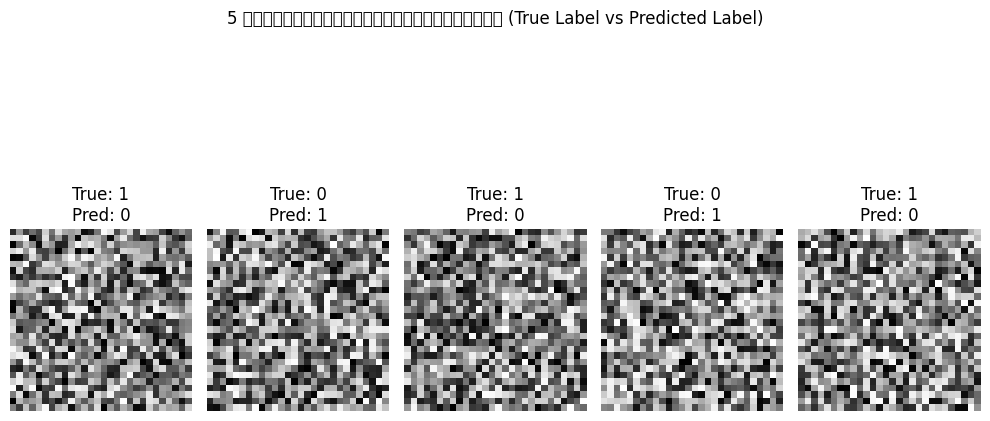

In [22]:
# --- YOUR CODE FOR EXERCISE 2 STARTS HERE ---
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

num_train_samples = 5000
num_test_samples = 1000
image_size = 28 * 28

# สร้างข้อมูลรูปภาพ 28x28 ที่มีค่าพิกเซล 0-255
fm_X_train_binary = np.random.randint(0, 256, size=(num_train_samples, 28, 28), dtype=np.uint8)
fm_X_test_binary = np.random.randint(0, 256, size=(num_test_samples, 28, 28), dtype=np.uint8)

# สร้างป้ายกำกับ (labels) 0 หรือ 1
fm_y_train = np.random.randint(0, 2, size=num_train_samples)
fm_y_test = np.random.randint(0, 2, size=num_test_samples)

print(f"รูปร่างเริ่มต้นของ fm_X_train_binary: {fm_X_train_binary.shape}")
print(f"รูปร่างเริ่มต้นของ fm_X_test_binary: {fm_X_test_binary.shape}")

# 1. Flattening: แปลงแต่ละรูปภาพ 28x28 ให้เป็น 1D array 784 ฟีเจอร
fm_X_train_flattened = fm_X_train_binary.reshape(num_train_samples, -1)
fm_X_test_flattened = fm_X_test_binary.reshape(num_test_samples, -1)

print(f"รูปร่างของ fm_X_train_flattened หลัง Flattening: {fm_X_train_flattened.shape}")
print(f"รูปร่างของ fm_X_test_flattened หลัง Flattening: {fm_X_test_flattened.shape}")

# 2. Scaling: ปรับค่าพิกเซลจาก [0, 255] ให้เป็น [0, 1]
fm_X_train_scaled = fm_X_train_flattened / 255.0
fm_X_test_scaled = fm_X_test_flattened / 255.0

print(f"ค่าพิกเซลสูงสุดใน fm_X_train_scaled: {fm_X_train_scaled.max()}")
print(f"ค่าพิกเซลต่ำสุดใน fm_X_train_scaled: {fm_X_train_scaled.min()}")

# 3. Train Logistic Regression
print("\n--- การฝึกโมเดล Logistic Regression ---")
model = LogisticRegression(solver='saga', random_state=42, n_jobs=-1, max_iter=200) # n_jobs=-1 ใช้ CPU ทั้งหมด
# Fit โมเดลบนข้อมูลที่ผ่านการประมวลผลแล้ว
model.fit(fm_X_train_scaled, fm_y_train)
print("โมเดล Logistic Regression ได้รับการฝึกเรียบร้อยแล้ว!")

# 4. Make Predictions: ทำนายผลบนข้อมูลทดสอบที่ประมวลผลแล้ว
print("\n--- การทำนายผล ---")
fm_y_pred = model.predict(fm_X_test_scaled)
print("ทำนายผลเสร็จสิ้น!")

# 5. Print Classification Report:
print("\n--- รายงานการจำแนกประเภท (Classification Report) ---")
print(classification_report(fm_y_test, fm_y_pred))

# สรุปค่าจาก classification_report
report = classification_report(fm_y_test, fm_y_pred, output_dict=True)
print(f"Accuracy: {report['accuracy']:.4f}")
print(f"Average Precision (weighted avg): {report['weighted avg']['precision']:.4f}")
print(f"Average Recall (weighted avg): {report['weighted avg']['recall']:.4f}")
print(f"Average F1-score (weighted avg): {report['weighted avg']['f1-score']:.4f}")

# 6. Visualize Misclassifications: แสดงภาพที่ทำนายผิดพลาด
print("\n--- แสดงภาพที่ทำนายผิดพลาด ---")

# หาดัชนีของรูปภาพที่ทำนายผิดพลาด
misclassified_indices = np.where(fm_y_pred != fm_y_test)[0]

print(f"จำนวนรูปภาพที่ทำนายผิดพลาดทั้งหมด: {len(misclassified_indices)}")

if len(misclassified_indices) > 0:
    # เลือก 5 รูปภาพที่ทำนายผิดพลาด (ถ้ามีอย่างน้อย 5 รูป)
    num_to_display = min(5, len(misclassified_indices))
    selected_misclassified_indices = np.random.choice(misclassified_indices, num_to_display, replace=False)

    plt.figure(figsize=(10, 6))
    for i, index in enumerate(selected_misclassified_indices):
        plt.subplot(1, num_to_display, i + 1)
        # นำรูปภาพกลับไปเป็นรูปร่าง 28x28 เพื่อแสดงผล
        plt.imshow(fm_X_test_binary[index], cmap='gray')
        plt.title(f"True: {fm_y_test[index]}\nPred: {fm_y_pred[index]}")
        plt.axis('off')
    plt.suptitle('5 ตัวอย่างภาพที่ทำนายผิดพลาด (True Label vs Predicted Label)')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # ปรับ layout ให้หัวข้อไม่ทับรูป
    plt.show()
else:
    print("ไม่พบรูปภาพที่ทำนายผิดพลาดในชุดทดสอบ")




## Part 3: 20 Newsgroups Dataset - Text Classification

### Load 20 Newsgroups Dataset

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics.

In [23]:
# Load the training and testing data
news_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)
news_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=42)

X_train_news, y_train_news = news_train.data, news_train.target
X_test_news, y_test_news = news_test.data, news_test.target

print(f"Number of training documents: {len(X_train_news)}")
print(f"Number of test documents: {len(X_test_news)}")
print(f"Categories: {news_train.target_names}")

Number of training documents: 11314
Number of test documents: 7532
Categories: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


### Explore Sample Document

In [24]:
# Print the first document and its class
## Write your code here


### Preprocessing: Text Vectorization Demonstration with `TfidfVectorizer`

$$
\text{TF-IDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D)
$$

Where:

$$
\text{TF}(t, d) = \frac{\text{number of word }t\text{ in } d}{\text{number of words in } d} \quad \text{ and } \quad
\text{IDF}(t, D) = \log\left(\frac{\text{total number of documents}}{\text{number of documents that contain word }t}\right).
$$

In [27]:
# Create a small list of sentences for demonstration
sample_sentences = [
    "This is the first document.",
    "This document is the second document.",
    "And this is the third one.",
    "Is this the first document?"
]

# Initialize TfidfVectorizer for demonstration
vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the sample sentences
# The output `sample_vec_output` will be a sparse matrix
sample_vec_output_sparse = vectorizer.fit_transform(sample_sentences)

# Convert to a dense NumPy array for easier viewing
sample_vec_output_dense = sample_vec_output_sparse.toarray()

print("\nVocabulary (word to index mapping):")
print(vectorizer.vocabulary_)

print("\nFeature names (words):")
print(vectorizer.get_feature_names_out())

print("\nTF-IDF matrix for sample sentences (dense format):")
print(sample_vec_output_dense)


Vocabulary (word to index mapping):
{'document': 0, 'second': 1}

Feature names (words):
['document' 'second']

TF-IDF matrix for sample sentences (dense format):
[[1.         0.        ]
 [0.78722298 0.61666846]
 [0.         0.        ]
 [1.         0.        ]]


### **Exercise 3: Apply TF-IDF Vectorization to Full Dataset**

Now, apply `TfidfVectorizer` to the actual training and testing datasets for the 20 Newsgroups classification task.

**Instructions:**

1.  **Initialize `TfidfVectorizer`:**
    *   Initialize `TfidfVectorizer`. Use `stop_words='english'` to remove common words.
2.  **Fit and Transform Training Data:**
    *   Call `fit_transform()` on `X_train_news` to learn the vocabulary and transform the training text into TF-IDF features. Store the result in `X_train_vec`.
3.  **Transform Test Data:**
    *   Call `transform()` on `X_test_news` using the *already fitted* vectorizer. Store the result in `X_test_vec`. **Crucially, do not call `fit_transform()` on the test data!** This would cause data leakage.
4.  **Initialize Logistic Regression:**
    *   Initialize `LogisticRegression(solver='saga')`. `saga` is a good solver when both number of samples and number of features are large.
5.  **Train the Model:**
    *   Fit the model on your `X_train_vec` and `y_train_news`.
6.  **Make Predictions:**
    *   Make predictions using `predict()` on the `X_test_vec`.
7.  **Evaluate the Model:**
    *   Print `classification_report` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)). What are the accuracy, average precision, average recall, and average f1-score?

In [28]:
# --- YOUR CODE FOR EXERCISE 3 STARTS HERE ---
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

X_train_news = newsgroups_train.data
y_train_news = newsgroups_train.target
X_test_news = newsgroups_test.data
y_test_news = newsgroups_test.target

print(f"จำนวนตัวอย่างในชุดฝึก: {len(X_train_news)}")
print(f"จำนวนตัวอย่างในชุดทดสอบ: {len(X_test_news)}")
print(f"ตัวอย่างข้อความแรกในชุดฝึก:\n{X_train_news[0][:200]}...\n") # แสดงแค่ 200 ตัวอักษรแรก

# 1. Initialize TfidfVectorizer
print("\n--- กำลังเตรียม TfidfVectorizer ---")
vectorizer = TfidfVectorizer(stop_words='english')
print("TfidfVectorizer ถูกเตรียมเรียบร้อยแล้ว!")

# 2. Fit and Transform Training Data
print("กำลัง Fit และ Transform ข้อมูลชุดฝึก...")
X_train_vec = vectorizer.fit_transform(X_train_news)
print(f"รูปร่างของ X_train_vec หลัง TF-IDF: {X_train_vec.shape}") # (จำนวนตัวอย่าง, จำนวนคำศัพท์)

# 3. Transform Test Data
print("กำลัง Transform ข้อมูลชุดทดสอบ...")
X_test_vec = vectorizer.transform(X_test_news)
print(f"รูปร่างของ X_test_vec หลัง TF-IDF: {X_test_vec.shape}") # ควรมีจำนวนคอลัมน์เท่ากับ X_train_vec

# 4. Initialize Logistic Regression
print("\n--- กำลังเตรียมโมเดล Logistic Regression ---")

model = LogisticRegression(solver='saga', random_state=42, n_jobs=-1, max_iter=500)
print("โมเดล Logistic Regression ถูกเตรียมเรียบร้อยแล้ว!")

# 5. Train the Model
print("กำลังฝึกโมเดล Logistic Regression...")
model.fit(X_train_vec, y_train_news)
print("โมเดล Logistic Regression ได้รับการฝึกเรียบร้อยแล้ว!")

# 6. Make Predictions
print("\n--- กำลังทำนายผลบนชุดทดสอบ ---")
y_pred_news = model.predict(X_test_vec)
print("ทำนายผลเสร็จสิ้น!")

# 7. Evaluate the Model
print("\n--- รายงานการจำแนกประเภท (Classification Report) ---")
print(classification_report(y_test_news, y_pred_news, target_names=newsgroups_test.target_names))

# สรุปค่าจาก classification_report
report_dict = classification_report(y_test_news, y_pred_news, output_dict=True)

print(f"\nAccuracy: {report_dict['accuracy']:.4f}")
# สำหรับ multi-class classification, weighted avg มักจะให้ภาพรวมที่ดีกว่า
print(f"Average Precision (weighted avg): {report_dict['weighted avg']['precision']:.4f}")
print(f"Average Recall (weighted avg): {report_dict['weighted avg']['recall']:.4f}")
print(f"Average F1-score (weighted avg): {report_dict['weighted avg']['f1-score']:.4f}")



จำนวนตัวอย่างในชุดฝึก: 11314
จำนวนตัวอย่างในชุดทดสอบ: 7532
ตัวอย่างข้อความแรกในชุดฝึก:
I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were ...


--- กำลังเตรียม TfidfVectorizer ---
TfidfVectorizer ถูกเตรียมเรียบร้อยแล้ว!
กำลัง Fit และ Transform ข้อมูลชุดฝึก...
รูปร่างของ X_train_vec หลัง TF-IDF: (11314, 101322)
กำลัง Transform ข้อมูลชุดทดสอบ...
รูปร่างของ X_test_vec หลัง TF-IDF: (7532, 101322)

--- กำลังเตรียมโมเดล Logistic Regression ---
โมเดล Logistic Regression ถูกเตรียมเรียบร้อยแล้ว!
กำลังฝึกโมเดล Logistic Regression...
โมเดล Logistic Regression ได้รับการฝึกเรียบร้อยแล้ว!

--- กำลังทำนายผลบนชุดทดสอบ ---
ทำนายผลเสร็จสิ้น!

--- รายงานการจำแนกประเภท (Classification Report) ---
                          precision    recall  f1-score   support

             alt.atheism       0.49      0.45      0.47       319
           comp.graphics       0